In [1]:

import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, LayerNormalization,LeakyReLU, Softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [3]:
#Load colorplot datasets. 
X = np.load('data.npz')['a'].reshape(5179, 200, 100, 1)

#Creating the labels. 
y = pd.read_excel('Labels_v1.xlsx', header = None).values

#Shuffling the dataset.
shuffler = np.random.permutation(len(y))
X = X[shuffler]
y = y[shuffler]
class_weights = generate_class_weights(y[:,0])

In [5]:
def train(net, filename):
    inputs = X
    
    # Define the K-fold Cross Validator
    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True)

    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=0.2)
    mc = ModelCheckpoint('best_modelCNN.h5', monitor='val_loss',
                     mode='min', verbose=1, save_best_only=True)
    # # annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    # # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, min_delta=0.0001, verbose=1)
    # datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
    #                             rotation_range=10,
    #                             fill_mode='nearest',
    #                             width_shift_range=0.1,
    #                             height_shift_range=0.1,
    #                             zoom_range=0.1,
    #                             # preprocessing_function= blur
    #                             )
    
    
    # opt = tf.keras.optimizers.Adam(
    # learning_rate=0.001,
    # beta_1=0.9,
    # beta_2=0.999,
    # epsilon=1e-07,
    # amsgrad=False,
    # name="Adam",    
    # )
    
    net.compile(loss='binary_crossentropy',
                optimizer="adam", metrics="accuracy")

    targets = np.asarray(y).astype('float32').reshape((-1,1))
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        #Train the model
        history = net.fit(inputs[train], targets[train],                       # changed expression for test features and labels
        validation_split=0.25,                                 # I removed validation for k-fold cross validation
        verbose=1, epochs=25, 
        class_weight = class_weights, callbacks=[es])
        
        plt.figure()
        plt.plot(history.history['loss'], label='training loss')
        plt.plot(history.history['val_loss'], label='validation loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()

        plt.show()
        #Prediction of the validation dataset 
        test_predictions = net.predict(inputs[test]).flatten()
        fold_no = fold_no + 1

    net.save(filename)

In [15]:

def build_cnn():
    net = Sequential()
#     net.add(BatchNormalization(input_shape=(200, 100, 1)))
    net.add(Conv2D(activation=LeakyReLU(),filters=32, kernel_size=(3, 3), input_shape=(200, 100, 1)))
    net.add(Conv2D(activation=LeakyReLU(),filters=32, kernel_size=(3, 3)))
    net.add(MaxPool2D(pool_size=(2, 2)))
    net.add(Conv2D(activation=LeakyReLU(),filters=64, kernel_size=(3, 3)))
    net.add(Conv2D(activation=LeakyReLU(),filters=64, kernel_size=(3, 3)))
    net.add(MaxPool2D(pool_size=(2, 2)))
    net.add(Flatten())
    net.add(Dense(512, activation=LeakyReLU()))
#     net.add(Dropout(rate=0.5))
    net.add(Dense(512, activation=LeakyReLU()))
    net.add(Dense(2, activation='softmax'))
    net.add(Flatten())

    # net.build(input_shape=(200, 100, 1))
    summary = net.summary()

    plot_model(net, to_file='network_structure.png', show_shapes=True)

    print(summary)

    return net

In [16]:
def test(filename):
    net = load_model(filename)
    labels_train = y
    
    outputs = net.predict(X)
    labels_predicted = np.argmax(outputs, axis=1)
    misclassified = sum(labels_predicted != labels_train)
    print('Percentage misclassified = ',
          100*misclassified/labels_train.size)

#     plt.figure(figsize=(8, 2))
# #     for i in range(0, 8):
# #         ax = plt.subplot(2, 8, i+1)
# #         plt.imshow(X[i, :].reshape(200, 100), cmap=plt.get_cmap('gray_r'))
# #         plt.title(labels_train[i])
# #         ax.get_xaxis().set_visible(False)
# #         ax.get_yaxis().set_visible(False)
# #     for i in range(0, 8):
# #         output = net.predict(X[i, :].reshape(1, 200, 100, 1))
# #         output = output[0, 0:]
# #         plt.subplot(2, 8, 8+i+1)
# #         plt.bar(np.arange(10.), output)
# #         plt.title(np.argmax(output))

    net.summary()
    from tensorflow.keras.utils import plot_model
    plot_model(net, to_file='network_structure_v2.png', show_shapes=True)
    plt.show()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 98, 32)       320       
                                                                 
 conv2d_13 (Conv2D)          (None, 196, 96, 32)       9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 98, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 46, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 94, 44, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 22, 64)       0         
 2D)                                                  

2022-02-15 11:39:43.309707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.9551 - accuracy: 0.4918

2022-02-15 11:40:38.313292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 63s 634ms/step - loss: 0.9551 - accuracy: 0.4918 - val_loss: 0.6937 - val_accuracy: 0.7568
Epoch 2/25
98/98 [==============================] - 58s 589ms/step - loss: 0.8544 - accuracy: 0.4950 - val_loss: 0.6934 - val_accuracy: 0.5058
Epoch 3/25
98/98 [==============================] - 58s 593ms/step - loss: 0.9361 - accuracy: 0.5233 - val_loss: 0.6956 - val_accuracy: 0.7886
Epoch 4/25
98/98 [==============================] - 58s 588ms/step - loss: 0.8489 - accuracy: 0.4854 - val_loss: 0.6932 - val_accuracy: 0.5029
Epoch 5/25
98/98 [==============================] - 52s 525ms/step - loss: 0.8498 - accuracy: 0.5169 - val_loss: 0.6983 - val_accuracy: 0.8292
Epoch 6/25
98/98 [==============================] - 53s 538ms/step - loss: 0.8539 - accuracy: 0.4516 - val_loss: 0.7010 - val_accuracy: 0.5396
Epoch 7/25
98/98 [==============================] - 55s 562ms/step - loss: 0.9047 - accuracy: 0.4644 - val_loss: 0.6934 - val_accuracy: 0.5183
Epoch 8/25

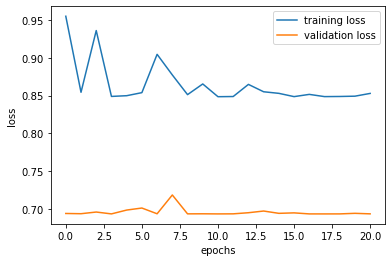

2022-02-15 11:58:40.224037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/25
98/98 [==============================] - 55s 559ms/step - loss: 0.8449 - accuracy: 0.4780 - val_loss: 0.6932 - val_accuracy: 0.7539
Epoch 2/25
98/98 [==============================] - 43s 436ms/step - loss: 0.8434 - accuracy: 0.5014 - val_loss: 0.6985 - val_accuracy: 0.8282
Epoch 3/25
98/98 [==============================] - 30s 303ms/step - loss: 0.8444 - accuracy: 0.5053 - val_loss: 0.6947 - val_accuracy: 0.8214
Epoch 4/25
98/98 [==============================] - 30s 308ms/step - loss: 0.8434 - accuracy: 0.5993 - val_loss: 0.6932 - val_accuracy: 0.2326
Epoch 5/25
98/98 [==============================] - 30s 310ms/step - loss: 0.8438 - accuracy: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.5454
Epoch 6/25
98/98 [==============================] - 30s 304ms/step - loss: 0.8454 - accuracy: 0.4902 - val_loss: 0.6932 - val_accuracy: 0.5270
Epoch 7/25
98/98 [==============================] - 31s 315ms/step - loss: 0.8437 - accuracy: 0.4689 - val_loss: 0.6932 - val_accuracy: 0.4517

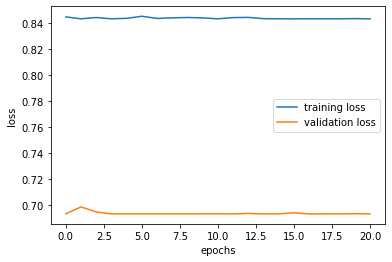

Epoch 1/25
98/98 [==============================] - 31s 315ms/step - loss: 0.8459 - accuracy: 0.5204 - val_loss: 0.6942 - val_accuracy: 0.8388
Epoch 2/25
98/98 [==============================] - 30s 306ms/step - loss: 0.8470 - accuracy: 0.5288 - val_loss: 0.6932 - val_accuracy: 0.3475
Epoch 3/25
98/98 [==============================] - 31s 317ms/step - loss: 0.8464 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.7886
Epoch 4/25
98/98 [==============================] - 30s 308ms/step - loss: 0.8470 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.5154
Epoch 5/25
98/98 [==============================] - 30s 304ms/step - loss: 0.8463 - accuracy: 0.4899 - val_loss: 0.6938 - val_accuracy: 0.1612
Epoch 6/25
98/98 [==============================] - 31s 317ms/step - loss: 0.8483 - accuracy: 0.5462 - val_loss: 0.6932 - val_accuracy: 0.2432
Epoch 7/25
98/98 [==============================] - 31s 314ms/step - loss: 0.8459 - accuracy: 0.4184 - val_loss: 0.6931 - val_accuracy: 0.3089

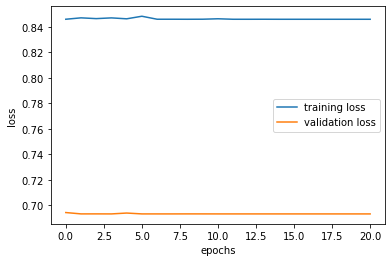

Epoch 1/25
98/98 [==============================] - 30s 305ms/step - loss: 0.8474 - accuracy: 0.4178 - val_loss: 0.6931 - val_accuracy: 0.2095
Epoch 2/25
98/98 [==============================] - 30s 309ms/step - loss: 0.8474 - accuracy: 0.4641 - val_loss: 0.6931 - val_accuracy: 0.3745
Epoch 3/25
98/98 [==============================] - 31s 312ms/step - loss: 0.8474 - accuracy: 0.4207 - val_loss: 0.6931 - val_accuracy: 0.8060
Epoch 4/25
98/98 [==============================] - 29s 299ms/step - loss: 0.8474 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.4189
Epoch 5/25
98/98 [==============================] - 30s 304ms/step - loss: 0.8474 - accuracy: 0.4902 - val_loss: 0.6931 - val_accuracy: 0.4112
Epoch 6/25
98/98 [==============================] - 30s 306ms/step - loss: 0.8474 - accuracy: 0.4731 - val_loss: 0.6931 - val_accuracy: 0.3803
Epoch 7/25
98/98 [==============================] - 30s 303ms/step - loss: 0.8474 - accuracy: 0.5166 - val_loss: 0.6931 - val_accuracy: 0.1708

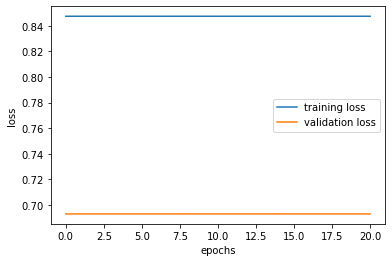

Epoch 1/25
98/98 [==============================] - 30s 308ms/step - loss: 0.4586 - accuracy: 0.4659 - val_loss: 0.6931 - val_accuracy: 0.4498
Epoch 2/25
98/98 [==============================] - 31s 312ms/step - loss: 0.4586 - accuracy: 0.4636 - val_loss: 0.6931 - val_accuracy: 0.4604
Epoch 3/25
98/98 [==============================] - 29s 295ms/step - loss: 0.4586 - accuracy: 0.4665 - val_loss: 0.6931 - val_accuracy: 0.4305
Epoch 4/25
98/98 [==============================] - 29s 297ms/step - loss: 0.4586 - accuracy: 0.4614 - val_loss: 0.6931 - val_accuracy: 0.4411
Epoch 5/25
98/98 [==============================] - 30s 310ms/step - loss: 0.4586 - accuracy: 0.4601 - val_loss: 0.6931 - val_accuracy: 0.4546
Epoch 6/25
98/98 [==============================] - 30s 301ms/step - loss: 0.4586 - accuracy: 0.4649 - val_loss: 0.6931 - val_accuracy: 0.4778
Epoch 7/25
98/98 [==============================] - 30s 301ms/step - loss: 0.4586 - accuracy: 0.4633 - val_loss: 0.6931 - val_accuracy: 0.4971

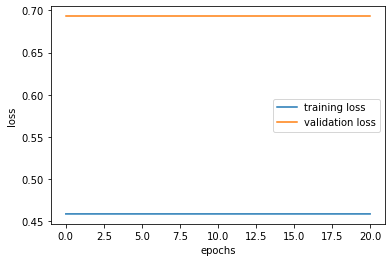

In [17]:
net_cnn = build_cnn()
train(net_cnn, 'cnn_for_5H.h5')

# earlystoping
# model checkpoint

In [ ]:
test('cnn_for_5H_trial1.h5')

2022-02-14 11:36:42.991288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
